In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
import MAna as ma

ma.set_seed()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd

data = pd.read_csv('ready_to_model_df.csv')
data.head()

,customer_id,new order,subscription information,new subscription,create customer,pause subscription,cancel subscription,pause subscription (failed payment),change subscription,reactivate subscription,event,nextBox,nextBoxDeliveryTime,currentBoxPrice,currentBox,currentBoxDeliveryTime,currentBoxStatus,last_event,time_since_last_event
0,6,12,1,4,0,0,0,0,0,0,3,23,15,41.9,22,15,0,3,0.0
1,6,0,1,4,0,0,0,0,0,0,3,23,15,41.9,22,15,0,3,0.0
2,6,0,1,0,0,0,0,0,0,0,3,23,15,41.9,22,15,0,3,0.0
3,6,12,1,4,0,0,0,0,0,0,3,3,9,35.2,3,9,0,3,0.0
4,6,0,1,4,0,0,0,0,0,0,3,3,9,35.2,3,9,0,3,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52586 entries, 0 to 52585
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          52586 non-null  object 
 1   new order                            52586 non-null  int64  
 2   subscription information             52586 non-null  int64  
 3   new subscription                     52586 non-null  int64  
 4   create customer                      52586 non-null  int64  
 5   pause subscription                   52586 non-null  int64  
 6   cancel subscription                  52586 non-null  int64  
 7   pause subscription (failed payment)  52586 non-null  int64  
 8   change subscription                  52586 non-null  int64  
 9   reactivate subscription              52586 non-null  int64  
 10  event                                52586 non-null  int64  
 11  nextBox                     

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.utils import resample

# Assuming X and y are your input and target data respectively
# Prepare the training data
X = data.drop(['event','time_since_last_event','customer_id'],axis=1)
y = data[['event','time_since_last_event']]

y['combined'] = y.event.astype(str) + '-' + y.time_since_last_event.astype(str)

# Use LabelEncoder to encode the combined column
label_encoder = LabelEncoder()
y['encoded'] = label_encoder.fit_transform(y['combined'])

# Combine X and y into a single array
data_ = np.column_stack((X, y['encoded']))

# Determine the class with fewer samples
minority_class = y['encoded'].value_counts().median() * 2

resampled_data = [resample(data_[data_[:, -1].astype(int) == i], n_samples=int(minority_class)) for i in y.encoded.unique()]

# Combine the resampled classes
balanced_data = np.vstack(resampled_data)

# Separate the features (X_balanced) and targets (y_balanced)
X_balanced = balanced_data[:, :-1]
y_balanced = balanced_data[:, -1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# X_train and y_train will be the training data
# X_val and y_val will be the validation data

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_2196\2281721015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['combined'] = y.event.astype(str) + '-' + y.time_since_last_event.astype(str)
C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_2196\2281721015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['encoded'] = label_encoder.fit_transform(y['combined'])


In [6]:
dates_we_have = y.time_since_last_event.value_counts().sort_index().index.tolist()

In [6]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=256))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=88, activation='softmax'))  # Adjust units based on the number of classes
    return model


# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Convert input and target data to the appropriate data type
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
# Verify the dimensions
# print(X_train.shape)  # Output: (num_samples, num_timesteps, 1)

# Update input_shape and num_classes accordingly
input_shape = (X_train.shape[1], 1)
num_classes = 88  # Number of classes

# Build the LSTM model
model = build_lstm_model(input_shape)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode the target variable
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Define early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

# Train the model with early stopping
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Once the model is trained
y_pred = np.argmax(model.predict(X_val), axis=1)

Epoch 1/100
81/81 [==============================] - 7s 24ms/step - loss: 4.4807 - accuracy: 0.0139 - val_loss: 4.4845 - val_accuracy: 0.0185
Epoch 2/100
81/81 [==============================] - 1s 14ms/step - loss: 4.4588 - accuracy: 0.0166 - val_loss: 4.3898 - val_accuracy: 0.0185
Epoch 3/100
81/81 [==============================] - 1s 14ms/step - loss: 4.3916 - accuracy: 0.0224 - val_loss: 4.3152 - val_accuracy: 0.0340
Epoch 4/100
81/81 [==============================] - 1s 14ms/step - loss: 4.2771 - accuracy: 0.0398 - val_loss: 4.2515 - val_accuracy: 0.0401
Epoch 5/100
81/81 [==============================] - 1s 13ms/step - loss: 4.1348 - accuracy: 0.0687 - val_loss: 3.9698 - val_accuracy: 0.1250
Epoch 6/100
81/81 [==============================] - 1s 15ms/step - loss: 3.9402 - accuracy: 0.0965 - val_loss: 3.8161 - val_accuracy: 0.1188
Epoch 7/100
81/81 [==============================] - 1s 16ms/step - loss: 3.7333 - accuracy: 0.1286 - val_loss: 3.6412 - val_accuracy: 0.1759
Epoch 

In [7]:
import eli5
from eli5.permutation_importance import get_score_importances
from sklearn.metrics import mean_absolute_error

cols = X.columns.to_list()
# Calculate feature importance using permutation importance
def calculate_permutation_importance(model, X, y):
    base_score, score_decreases = get_score_importances(
        lambda x,y: mean_absolute_error(y, np.argmax(model.predict(x), axis=1)), X, y, n_iter=5, random_state=42
    )
    feature_importances = np.mean(score_decreases, axis=0)
    feature_names = cols # Replace with your feature names
    return dict(zip(feature_names, feature_importances))

# Reshape validation data for prediction
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Calculate permutation importance
feature_importances = calculate_permutation_importance(model, X_val_reshaped, y_val)

26/26 [==============================] - 0s 4ms/step


<Axes: >

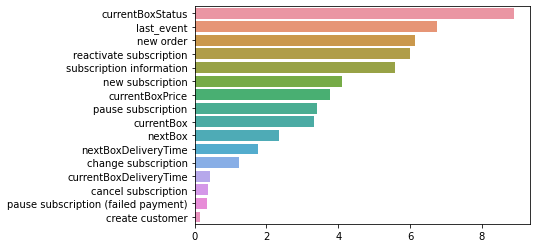

In [8]:
import seaborn as sns

feature_importances = pd.Series(feature_importances.values(),index=feature_importances.keys()).sort_values(ascending=True)
sns.barplot(x = np.abs(feature_importances), y=feature_importances.index)

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val,y_pred)

0.6074074074074074

In [10]:
import plotly.express as px

px.histogram(y_pred)

In [11]:
px.histogram(y_val)

In [12]:
px.histogram(np.argmax(y_train, axis=1))

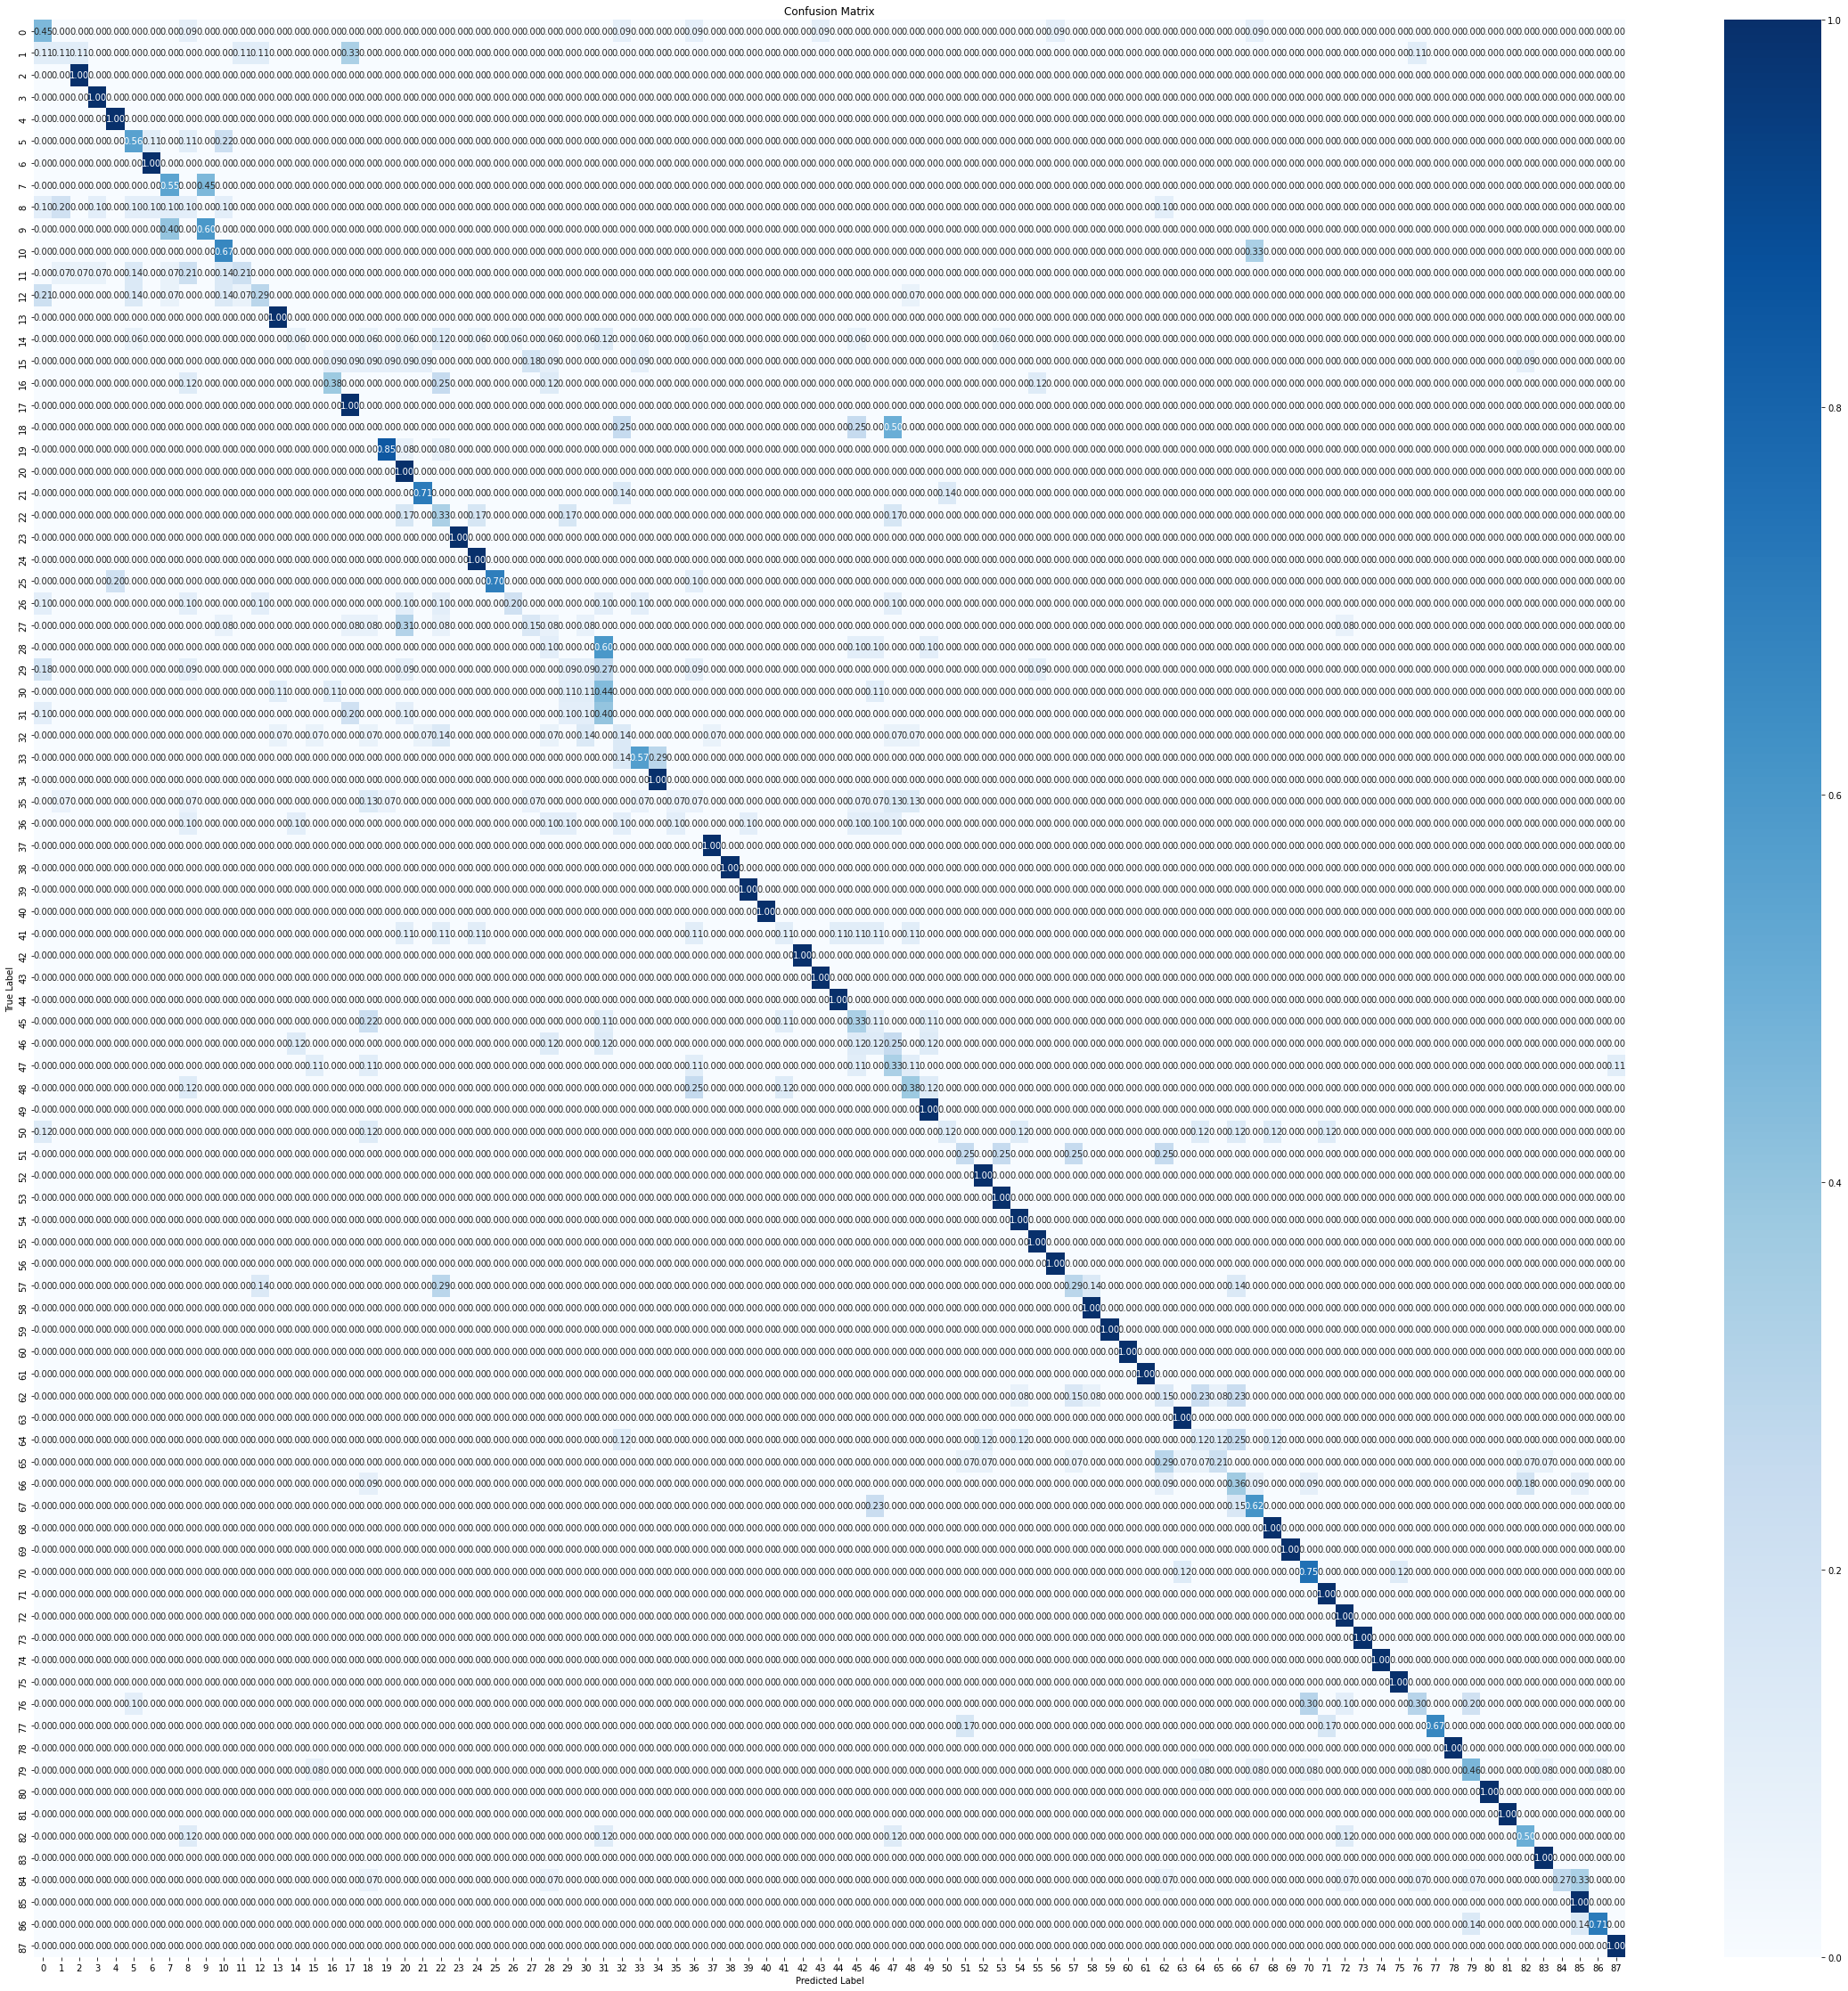

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(40, 40))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_val,y_pred, [i for i in range(88)])

In [14]:
def reclass(arr):
    # Suppose you have the encoded column 'encoded' and want to retrieve the original two columns

    # Decode the encoded column using the LabelEncoder inverse_transform
    rearr = label_encoder.inverse_transform(arr)

    # Split the 'decoded' column back into 'column1' and 'column2'
    df = pd.DataFrame()
    df[['event', 'date']] = pd.Series(rearr).str.split('-', expand=True)

    # Print the original columns
    return df

y_val_dec = reclass(y_val.astype(int))
y_pred_dec = reclass(y_pred.astype(int))

In [15]:
accuracy_score(y_val_dec.event,y_pred_dec.event)

0.8592592592592593

In [16]:
accuracy_score(y_val_dec.date,y_pred_dec.date)

0.6283950617283951

In [17]:
px.histogram(y_val_dec.event.sort_values())

In [18]:
px.histogram(y_pred_dec.event.sort_values())

In [19]:
px.histogram(y_val_dec.date.sort_values())

In [20]:
px.histogram(y_pred_dec.date.sort_values())

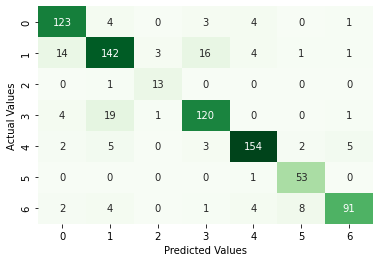

In [21]:
import MAna as ma

ma.confusion_matrix(y_val_dec.event,y_pred_dec.event)

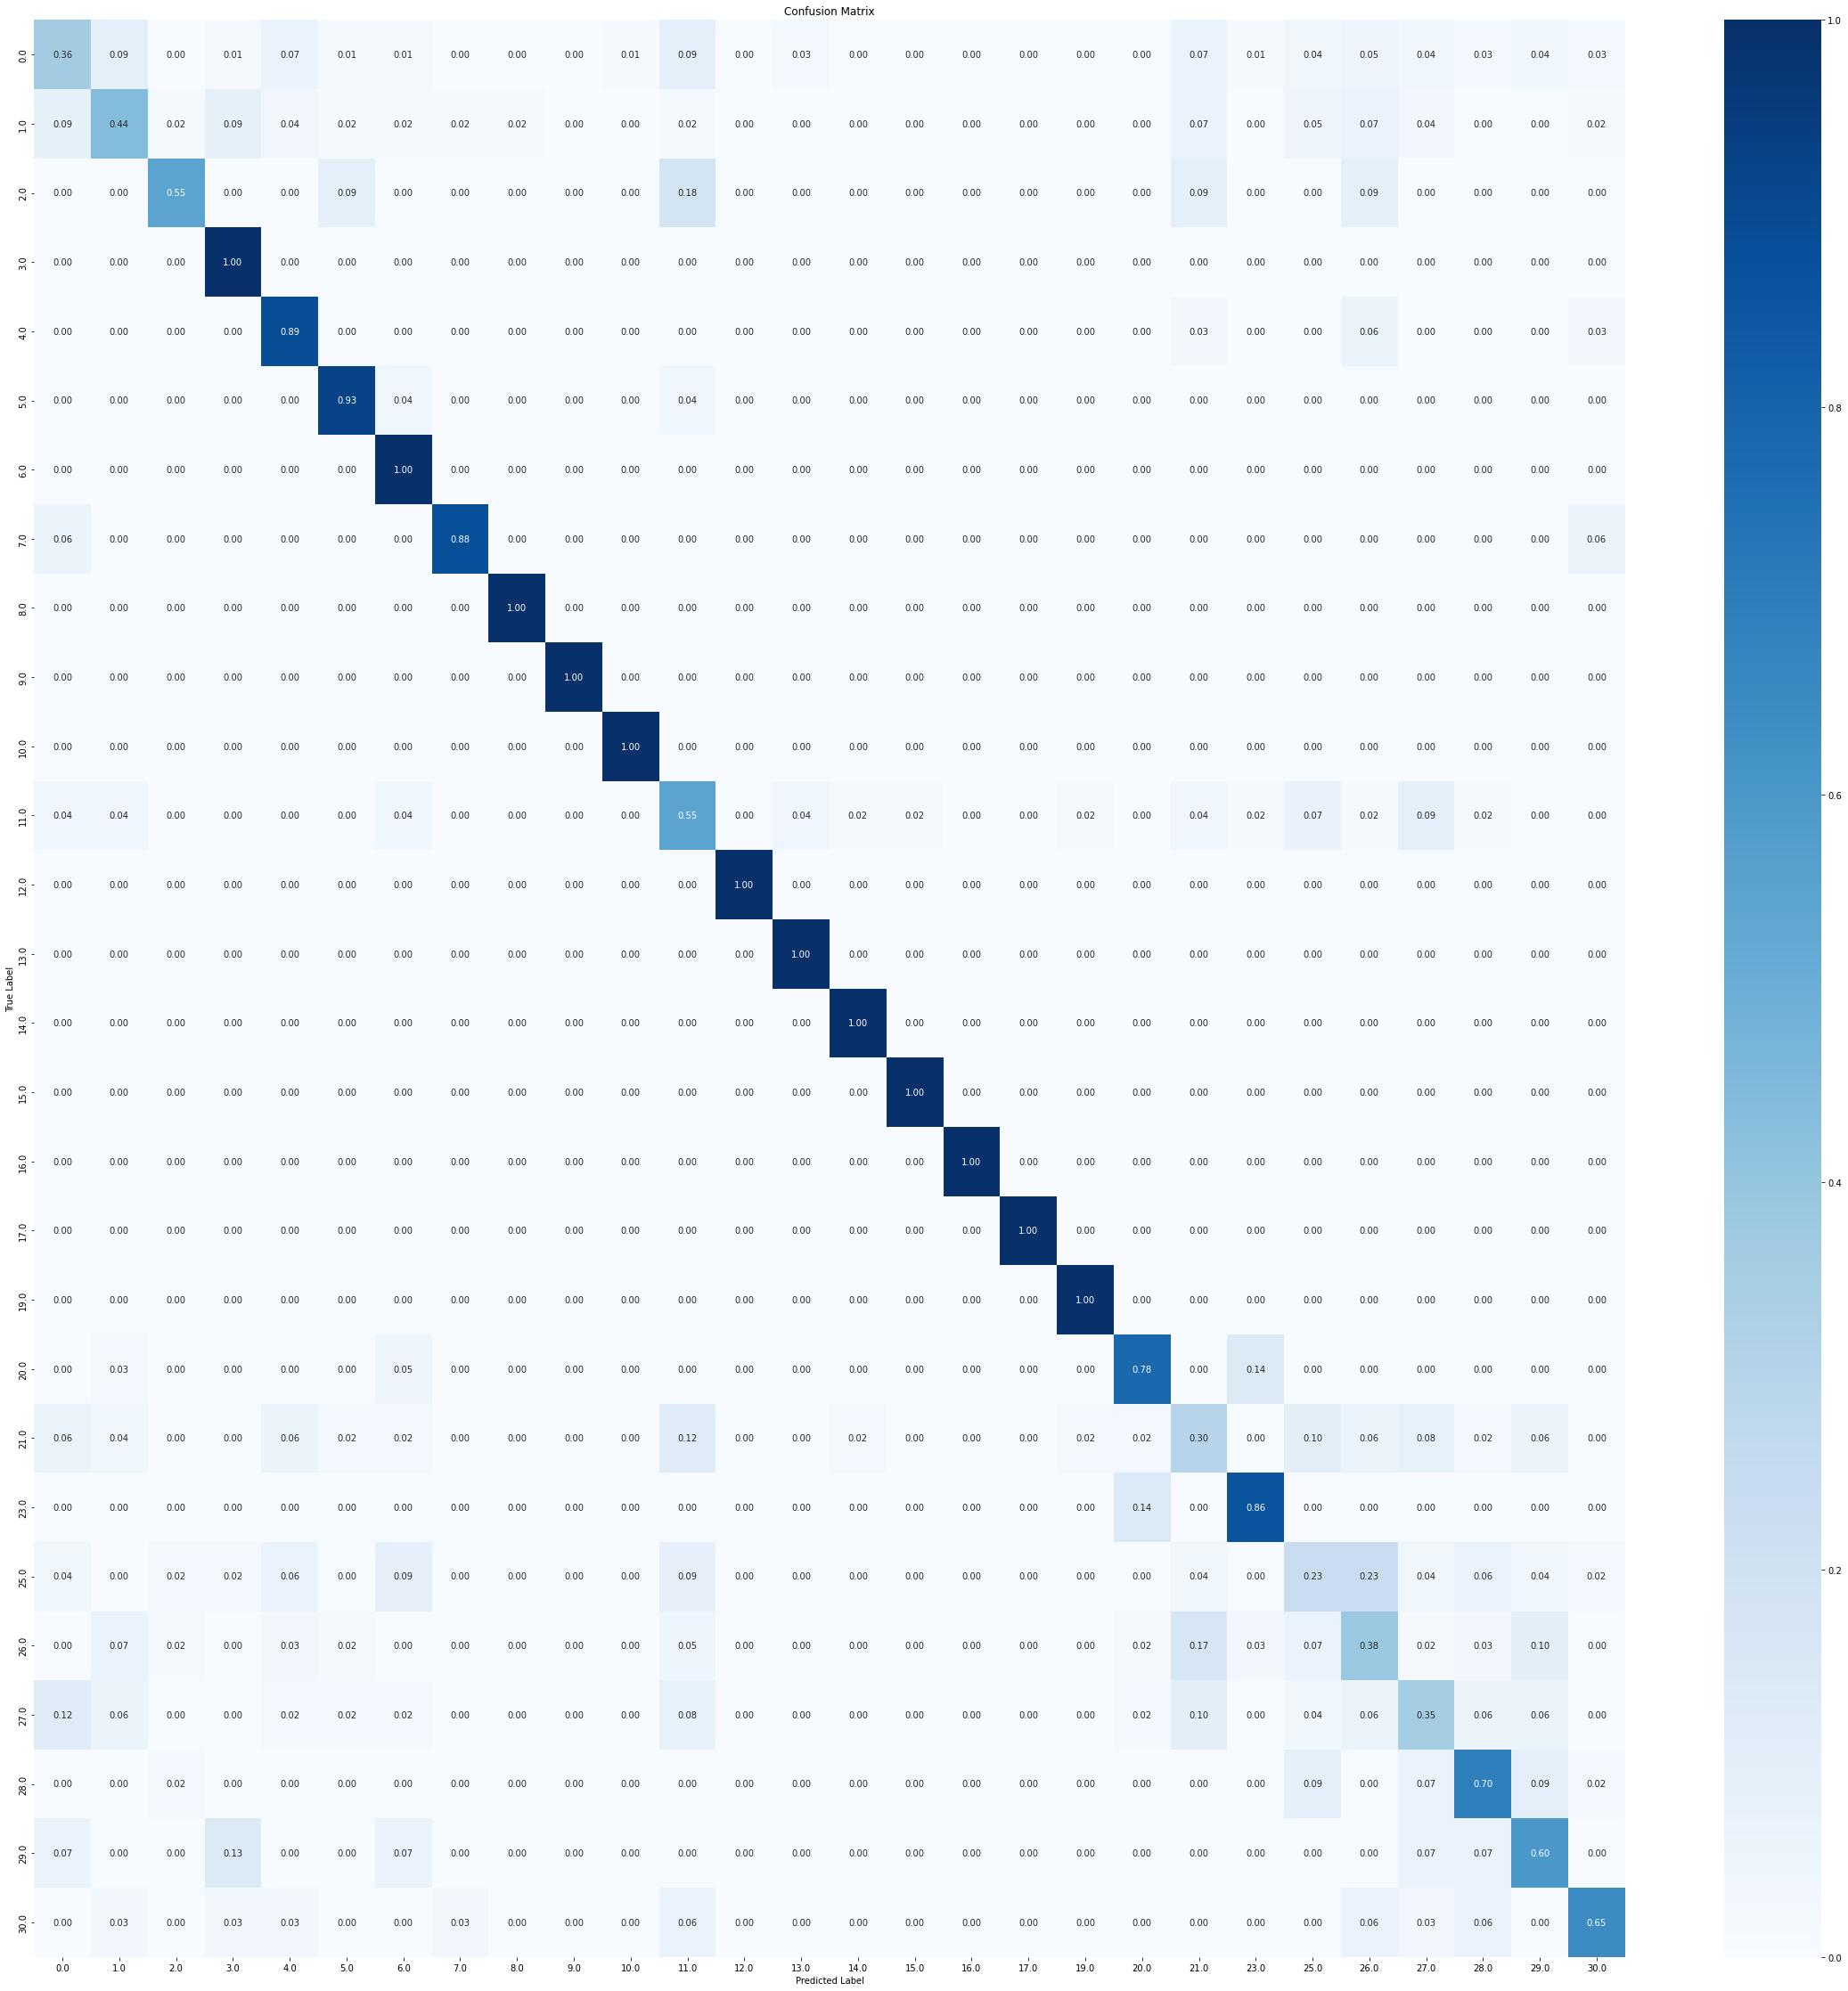

In [22]:
plot_confusion_matrix(y_val_dec.date,y_pred_dec.date,dates_we_have)

In [23]:
import pickle
import datetime

classnames = [i for i in range(88)]
def predict(model, row):
    predictions = model.predict(row)
    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    df = reclass(np.array([predicted_class]))

    # Load the trained XGBoost model from the .pkl file
    with open('label_encoders.pkl', 'rb') as file:
        encoders = pickle.load(file)

    event = encoders['event'].inverse_transform(df.iloc[:,0].astype(int))[0]
    date = df.iloc[:,1].astype(float)

    date = datetime.date.today() + datetime.timedelta(days=date.values[0]) 
    return event, date, confidence

predict(model, X_val[[9]])

1/1 [==============================] - 0s 27ms/step


('reactivate subscription', datetime.date(2023, 6, 6), 99.52)

In [24]:
model.save('LSTM model.h5')

In [25]:
feature_importances

currentBoxStatus                      -8.887901
last_event                            -6.746173
new order                             -6.146667
reactivate subscription               -5.987407
subscription information              -5.592346
new subscription                      -4.105926
currentBoxPrice                       -3.771358
pause subscription                    -3.402469
currentBox                            -3.331358
nextBox                               -2.348148
nextBoxDeliveryTime                   -1.765679
change subscription                   -1.231111
currentBoxDeliveryTime                -0.425679
cancel subscription                   -0.370370
pause subscription (failed payment)   -0.337778
create customer                       -0.137531
dtype: float64

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.utils import resample

# Assuming X and y are your input and target data respectively
# Prepare the training data
X = data.drop(['event','time_since_last_event','customer_id','create customer'],axis=1)
y = data[['event','time_since_last_event']]

y['combined'] = y.event.astype(str) + '-' + y.time_since_last_event.astype(str)

# Use LabelEncoder to encode the combined column
label_encoder = LabelEncoder()
y['encoded'] = label_encoder.fit_transform(y['combined'])

# Combine X and y into a single array
data_ = np.column_stack((X, y['encoded']))

# Determine the class with fewer samples
minority_class = y['encoded'].value_counts().median() * 2

resampled_data = [resample(data_[data_[:, -1].astype(int) == i], n_samples=int(minority_class)) for i in y.encoded.unique()]

# Combine the resampled classes
balanced_data = np.vstack(resampled_data)

# Separate the features (X_balanced) and targets (y_balanced)
X_balanced = balanced_data[:, :-1]
y_balanced = balanced_data[:, -1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# X_train and y_train will be the training data
# X_val and y_val will be the validation data

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_13756\3314458560.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_13756\3314458560.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=256))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=88, activation='softmax'))  # Adjust units based on the number of classes
    return model


# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Convert input and target data to the appropriate data type
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
# Verify the dimensions
# print(X_train.shape)  # Output: (num_samples, num_timesteps, 1)

# Update input_shape and num_classes accordingly
input_shape = (X_train.shape[1], 1)
num_classes = 88  # Number of classes

# Build the LSTM model
model = build_lstm_model(input_shape)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode the target variable
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Define early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

# Train the model with early stopping
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Once the model is trained
y_pred = np.argmax(model.predict(X_val), axis=1)

Epoch 1/100
81/81 [==============================] - 5s 29ms/step - loss: 4.4823 - accuracy: 0.0081 - val_loss: 4.4802 - val_accuracy: 0.0062
Epoch 2/100
81/81 [==============================] - 1s 12ms/step - loss: 4.4768 - accuracy: 0.0120 - val_loss: 4.4598 - val_accuracy: 0.0046
Epoch 3/100
81/81 [==============================] - 1s 12ms/step - loss: 4.4589 - accuracy: 0.0116 - val_loss: 4.4414 - val_accuracy: 0.0093
Epoch 4/100
81/81 [==============================] - 1s 12ms/step - loss: 4.4012 - accuracy: 0.0170 - val_loss: 4.3702 - val_accuracy: 0.0201
Epoch 5/100
81/81 [==============================] - 1s 13ms/step - loss: 4.3179 - accuracy: 0.0255 - val_loss: 4.2579 - val_accuracy: 0.0309
Epoch 6/100
81/81 [==============================] - 1s 13ms/step - loss: 4.1590 - accuracy: 0.0618 - val_loss: 4.0812 - val_accuracy: 0.0849
Epoch 7/100
81/81 [==============================] - 1s 13ms/step - loss: 4.0138 - accuracy: 0.0869 - val_loss: 3.8745 - val_accuracy: 0.1173
Epoch 

In [28]:
import eli5
from eli5.permutation_importance import get_score_importances
from sklearn.metrics import mean_absolute_error

cols = X.columns.to_list()
# Calculate feature importance using permutation importance
def calculate_permutation_importance(model, X, y):
    base_score, score_decreases = get_score_importances(
        lambda x,y: mean_absolute_error(y, np.argmax(model.predict(x), axis=1)), X, y, n_iter=5, random_state=42
    )
    feature_importances = np.mean(score_decreases, axis=0)
    feature_names = cols # Replace with your feature names
    return dict(zip(feature_names, feature_importances))

# Reshape validation data for prediction
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Calculate permutation importance
feature_importances = calculate_permutation_importance(model, X_val_reshaped, y_val)

26/26 [==============================] - 0s 5ms/step


<Axes: >

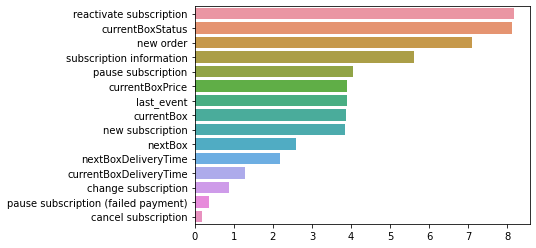

In [29]:
import seaborn as sns

feature_importances = pd.Series(feature_importances.values(),index=feature_importances.keys()).sort_values(ascending=True)
sns.barplot(x = np.abs(feature_importances), y=feature_importances.index)

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val,y_pred)

0.5950617283950618

In [31]:
import plotly.express as px

px.histogram(y_pred)

In [32]:
px.histogram(y_val)

In [33]:
px.histogram(np.argmax(y_train, axis=1))

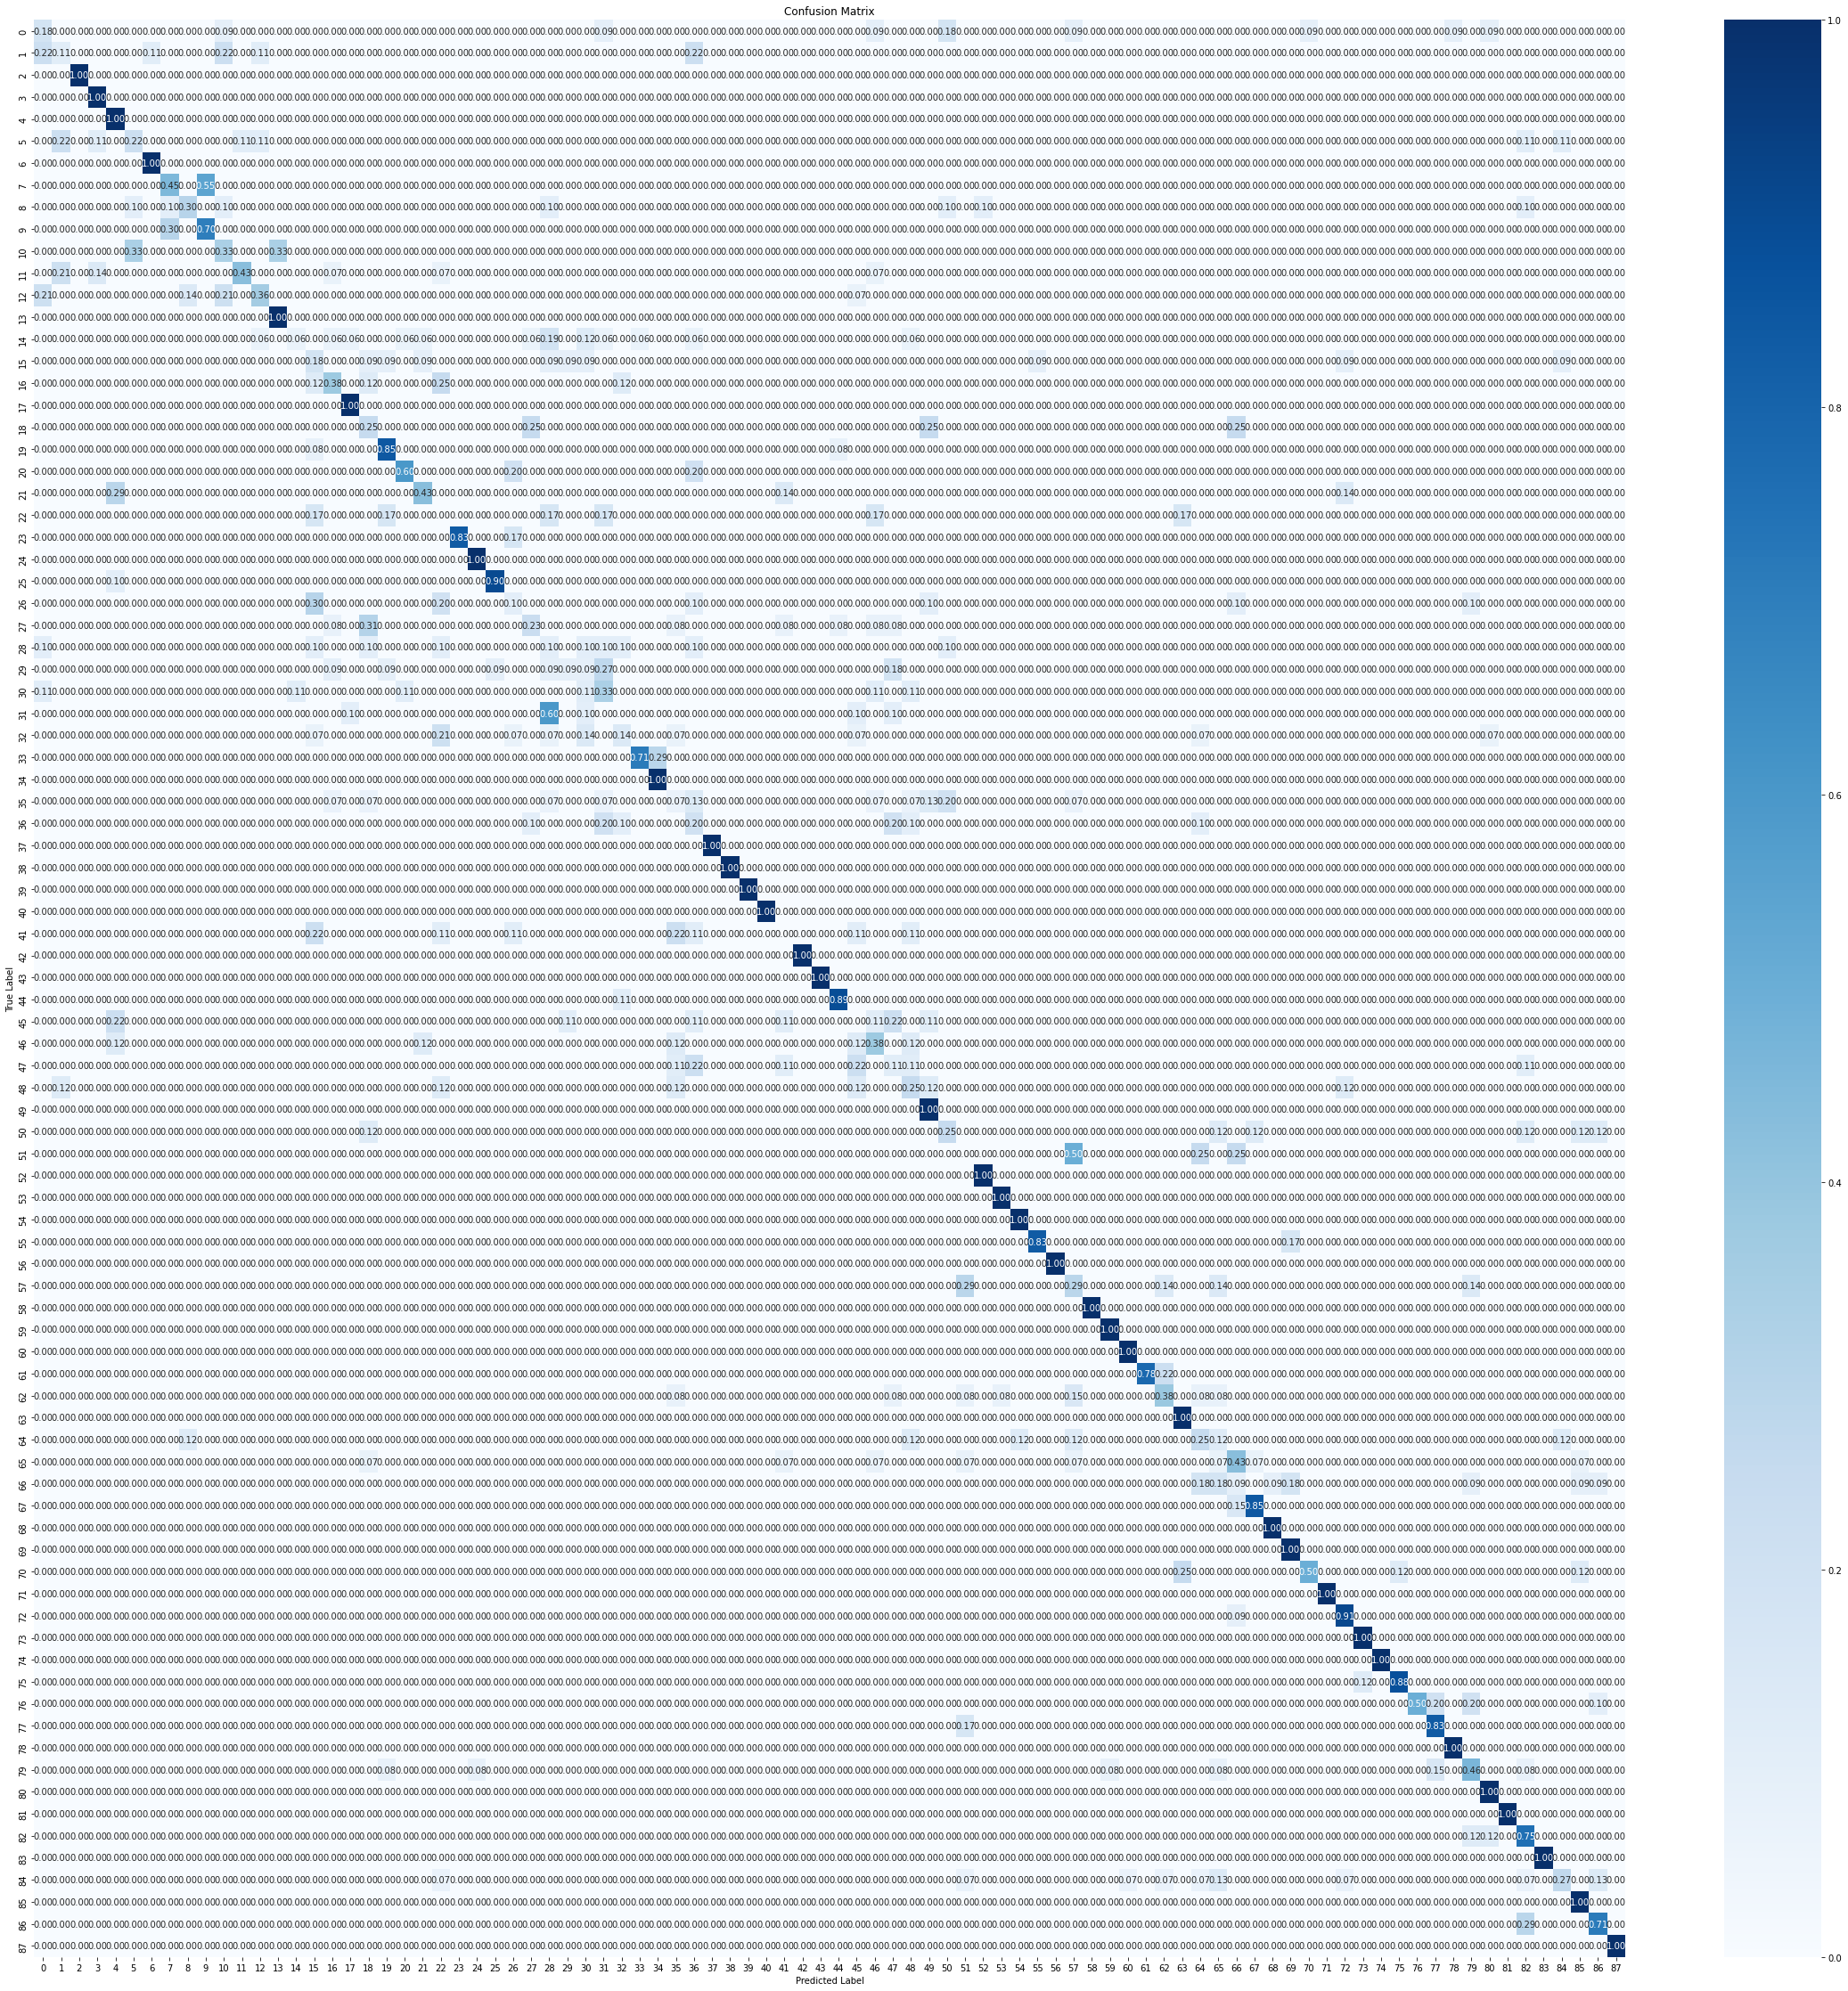

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(40, 40))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_val,y_pred, [i for i in range(88)])

In [ ]:
def reclass(arr):
    # Suppose you have the encoded column 'encoded' and want to retrieve the original two columns

    # Decode the encoded column using the LabelEncoder inverse_transform
    rearr = label_encoder.inverse_transform(arr)

    # Split the 'decoded' column back into 'column1' and 'column2'
    df = pd.DataFrame()
    df[['event', 'date']] = pd.Series(rearr).str.split('-', expand=True)

    # Print the original columns
    return df

y_val_dec = reclass(y_val.astype(int))
y_pred_dec = reclass(y_pred.astype(int))

In [36]:
accuracy_score(y_val_dec.event,y_pred_dec.event)

0.8493827160493828

In [37]:
accuracy_score(y_val_dec.date,y_pred_dec.date)

0.6172839506172839

In [38]:
px.histogram(y_val_dec.event.sort_values())

In [39]:
px.histogram(y_pred_dec.event.sort_values())

In [40]:
px.histogram(y_val_dec.date.sort_values())

In [41]:
px.histogram(y_pred_dec.date.sort_values())

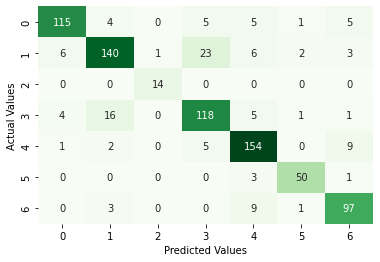

In [42]:
import MAna as ma

ma.confusion_matrix(y_val_dec.event,y_pred_dec.event)

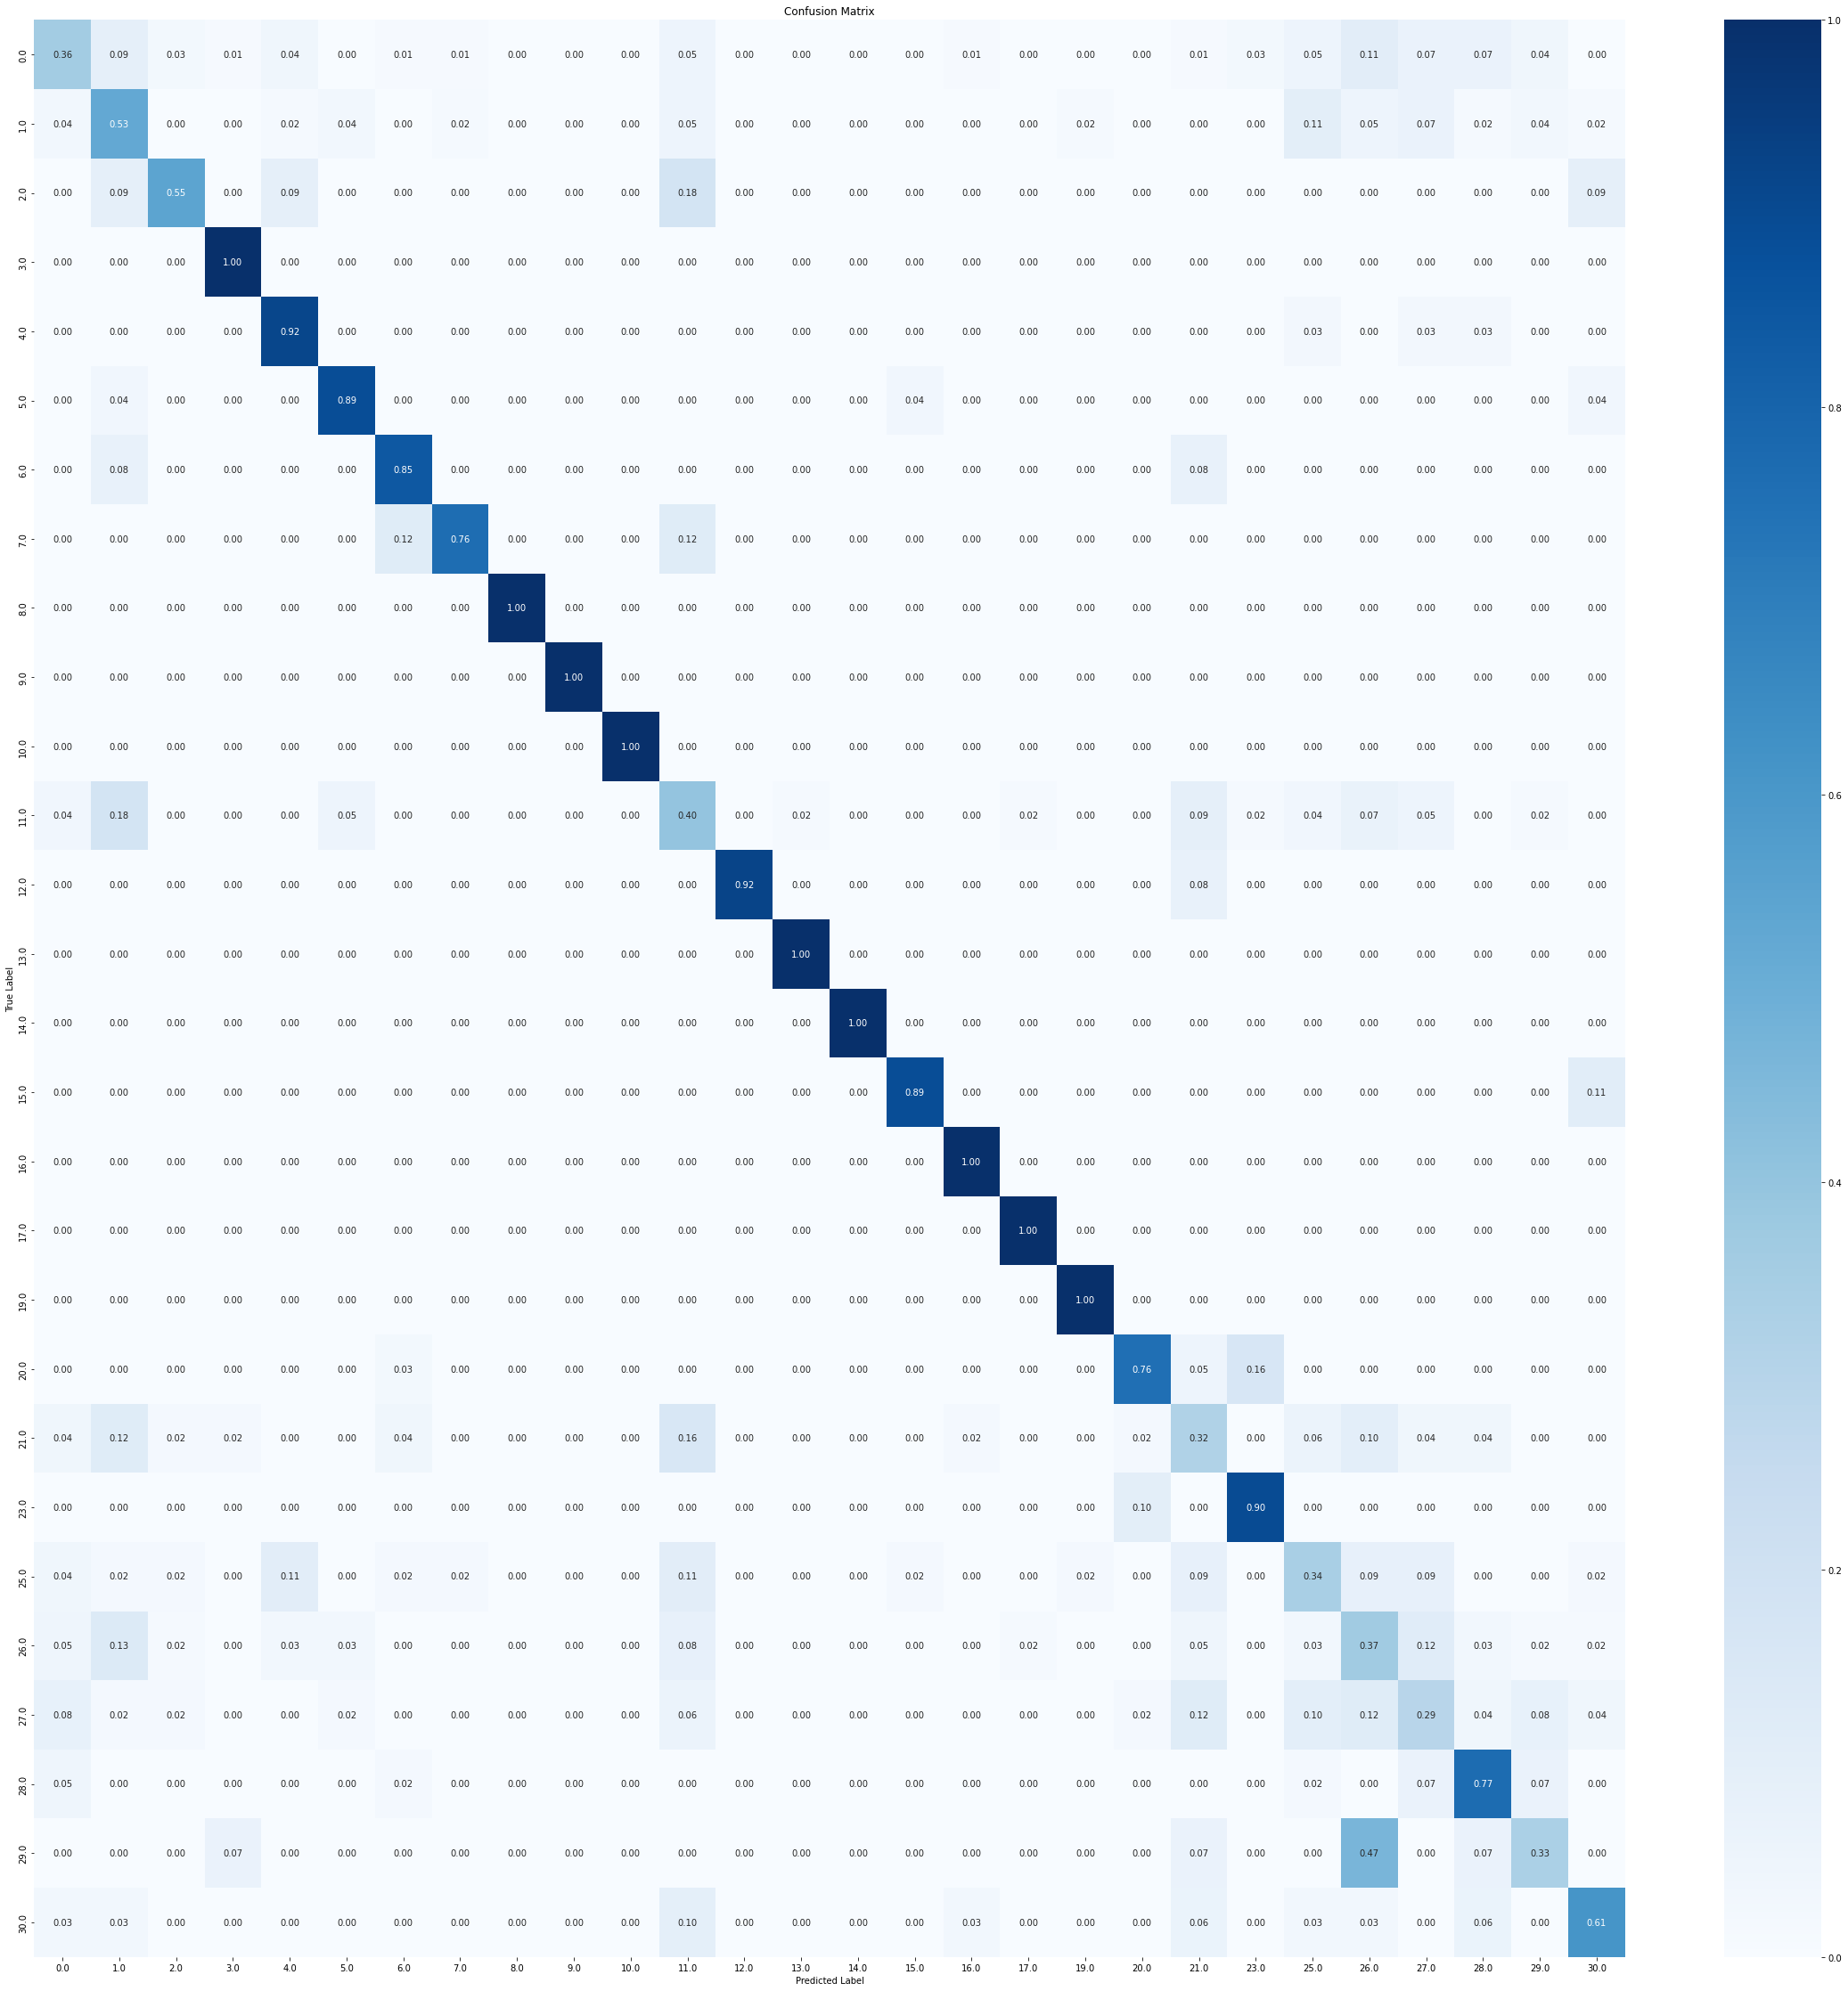

In [43]:
plot_confusion_matrix(y_val_dec.date,y_pred_dec.date,dates_we_have)

In [ ]:
import pickle
import datetime

classnames = [i for i in range(88)]
def predict(model, row):
    predictions = model.predict(row)
    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    df = reclass(np.array([predicted_class]))

    # Load the trained XGBoost model from the .pkl file
    with open('label_encoders.pkl', 'rb') as file:
        encoders = pickle.load(file)

    event = encoders['event'].inverse_transform(df.iloc[:,0].astype(int))[0]
    date = df.iloc[:,1].astype(float)

    date = datetime.date.today() + datetime.timedelta(days=date.values[0]) 
    return event, date, confidence

predict(model, X_val[[9]])

In [45]:
model.save('LSTM model S.h5')

csv

In [18]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('LSTM model.h5')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.utils import resample

# Assuming X and y are your input and target data respectively
# Prepare the training data
X = data.drop(['event','time_since_last_event'],axis=1)
y = data[['event','time_since_last_event']]

y['combined'] = y.event.astype(str) + '-' + y.time_since_last_event.astype(str)

# Use LabelEncoder to encode the combined column
label_encoder = LabelEncoder()
y['encoded'] = label_encoder.fit_transform(y['combined'])

# Combine X and y into a single array
data_ = np.column_stack((X, y['encoded']))

# Determine the class with fewer samples
minority_class = y['encoded'].value_counts().median() * 2

resampled_data = [resample(data_[data_[:, -1].astype(int) == i], n_samples=int(minority_class)) for i in y.encoded.unique()]

# Combine the resampled classes
balanced_data = np.vstack(resampled_data)

# Separate the features (X_balanced) and targets (y_balanced)
X_balanced = balanced_data[:, :-1]
y_balanced = balanced_data[:, -1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# X_train and y_train will be the training data
# X_val and y_val will be the validation data

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_17844\3821589712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['combined'] = y.event.astype(str) + '-' + y.time_since_last_event.astype(str)
C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_17844\3821589712.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['encoded'] = label_encoder.fit_transform(y['combined'])


In [24]:
X_val[:,1:]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 24, 16, 52.9, 23, 16, 1, 3],
      dtype=object)

In [27]:
np.array(y_pred.astype(int))

(810, 88)

In [46]:
df = reclass(np.array(y_val.astype(int)))
# Load the trained XGBoost model from the .pkl file
with open('label_encoders.pkl', 'rb') as file:
    encoders = pickle.load(file)

real_event = encoders['event'].inverse_transform(df.iloc[:,0].astype(int))
real_date = df.iloc[:,1].astype(float)

y_pred = np.argmax(model.predict(X_val[:,1:].astype(int)), axis=1)
df = reclass(np.array(y_pred.astype(int)))

pred_event = encoders['event'].inverse_transform(df.iloc[:,0].astype(int))
pred_date = df.iloc[:,1].astype(float)

26/26 [==============================] - 0s 16ms/step


In [47]:
print(len(X_val),len(real_event),len(pred_date))

810 810 810


In [48]:
real_event.shape

(810,)

In [57]:
result_data = {'customer ID': [],
               'real event' : [],
               'real date' : [],
               'predicted event' :[],
               'predicted date' :[]}

for i in range(len(X_val)):
    result_data['customer ID'].append(X_val[i,0])
    result_data['real event'].append(real_event[i])
    result_data['real date'].append(datetime.date.today() + datetime.timedelta(days=real_date[i]))
    result_data['predicted event'].append(pred_event[i])
    result_data['predicted date'].append(datetime.date.today() + datetime.timedelta(days=pred_date[i]))

res_df = pd.DataFrame(result_data)
res_df

,customer ID,real event,real date,predicted event,predicted date
0,11376,pause subscription (failed payment),2023-06-07,pause subscription (failed payment),2023-06-07
1,2003,pause subscription,2023-06-11,pause subscription,2023-06-07
2,666,create customer,2023-06-07,create customer,2023-06-07
3,668,change subscription,2023-06-27,change subscription,2023-06-27
4,1828,new subscription,2023-06-21,new subscription,2023-06-21
...,...,...,...,...,...
805,2319,pause subscription,2023-06-19,pause subscription,2023-06-19
806,2906,cancel subscription,2023-06-06,change subscription,2023-06-15
807,2690,new subscription,2023-06-22,new subscription,2023-06-22
808,3113,pause subscription (failed payment),2023-07-05,pause subscription (failed payment),2023-07-05


In [58]:
res_df.to_csv('results.csv',index=False)